In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

ABCD_PATH = '../../ABCD'
IDENTIFIERS = ['src_subject_id', 'eventname']
EVENTS = ['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1']
NETWORKS = {
    'ad': 'auditory',
    'cgc': 'cingulo-opercular',
    'ca': 'cingulo-parietal',
    'dt': 'default',
    'dla': 'dorsal attention',
    'fo': 'fronto-parietal',
    'n': None,
    'rspltp': 'retrosplenial temporal',
    'smh': 'sensorimotor hand',
    'smm': 'sensorimotor mouth',
    'sa': 'salience',
    'vta': 'ventral attention',
    'vs': 'visual'
}

In [2]:
betnet = pd.read_csv(os.path.join(ABCD_PATH, 'abcd_betnet02.tsv'), sep='\t',
                     skiprows=[1], index_col=IDENTIFIERS)

inclusion = pd.read_csv(os.path.join(ABCD_PATH, 'abcd_imgincl01.tsv'), sep='\t',
                        skiprows=[1], index_col=IDENTIFIERS)
inclusion.dropna(subset=['visit'], inplace=True)
inclusion = inclusion.loc[~inclusion.index.duplicated(keep='last')]

covariates = pd.read_csv('output/abcd_covariates.csv', index_col=IDENTIFIERS)

In [3]:
include = inclusion.loc[inclusion['imgincl_rsfmri_include'] == 1]
subs_long = [sub for sub, df in include.groupby(level='src_subject_id') if len(df) == 2]

# Teeuw-GeneticEnvironmental-2019

Longitudinal functional connectivity between/within

## Demographics

### Age

In [5]:
age_month = covariates.loc[idx[subs_long, EVENTS], 'interview_age']
age_month_diff = age_month.groupby(level='src_subject_id').diff().dropna().droplevel('eventname')

data_age = (age_month / 12).reset_index('eventname').rename(
    columns={'eventname':'Time Point'}).replace(
    {EVENTS[0]:'baseline', EVENTS[1]:'year 2'})

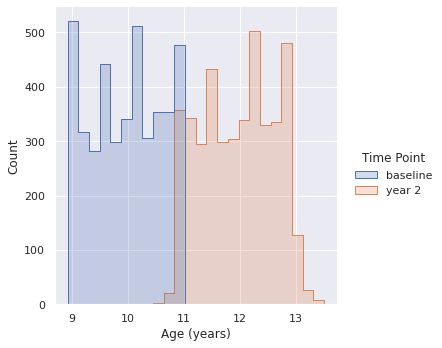

In [6]:
g = sns.displot(data_age, x='interview_age', hue='Time Point', element='step')
g.set_xlabels('Age (years)')

plt.show()

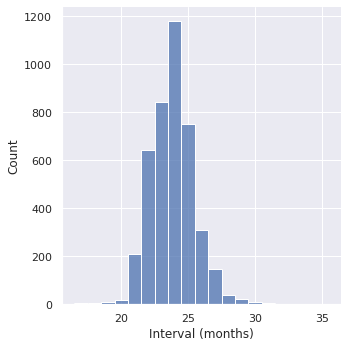

In [7]:
g = sns.displot(age_month_diff, discrete=True)
g.set_xlabels('Interval (months)')

plt.show()

### Sex

In [8]:
sex = covariates.loc[idx[subs_long, EVENTS[1]], 'sex']

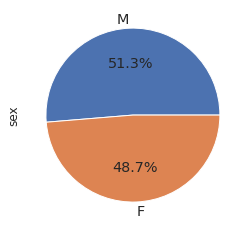

In [9]:
ax = sex.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'large'})

plt.show()

### Race

In [10]:
race = covariates.loc[idx[subs_long, EVENTS[1]], 'race.6level']

In [11]:
data_race = race.value_counts(dropna=False)
data_race.loc['Other'] = data_race.loc[['Other', 'AIAN/NHPI', np.nan]].sum()
data_race = data_race.drop([np.nan, 'AIAN/NHPI']).rename({'Other':'Other/Unknown'})

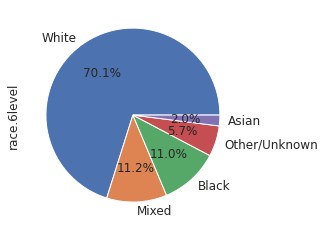

In [12]:
ax = data_race.plot.pie(autopct='%1.1f%%', textprops={'size':'medium'})

plt.show()

## Mean Framewise Displacement

In [13]:
meanmotion = betnet.loc[subs_long, 'rsfmri_c_ngd_meanmotion']

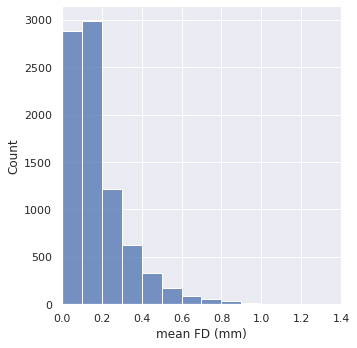

In [14]:
g = sns.displot(meanmotion, binwidth=0.1, binrange=(0, 1.4))
g.set(xlim=(0, 1.4))
g.set_xlabels('mean FD (mm)')

plt.show()

## Resting-State Networks

In [15]:
column_template = 'rsfmri_c_ngd_{0}_ngd_{1}'
network_codes = [n for n, name in NETWORKS.items() if name is not None]

network_columns = []
for i in range(len(network_codes)):
    for j in range(i+1):
        network_columns.append(column_template.format(network_codes[i], network_codes[j]))

In [16]:
def columns_to_2d(flat_tril):
    """flat series to 2D tril ndarray"""
    dim = int(np.sqrt(flat_tril.shape[0] * 2))
    matrix = np.full((dim, dim), np.nan)
    
    c = 0
    for i in range(dim):
        for j in range(i+1):
            matrix[i,j] = flat_tril.iloc[c]
            c += 1
    
    return matrix

def label_2d(matrix, codes):
    """2D tril ndarray to labeled 2D dataframe for visualization"""
    labels = []
    for code in codes:
        if code == 'rspltp':
            labels.append('RST')
        else:
            labels.append(code.upper())
    
    return pd.DataFrame(matrix, index=labels, columns=labels)

### Group Level

In [17]:
betnet_baseline = betnet.loc[idx[subs_long, EVENTS[0]], network_columns].droplevel('eventname')
betnet_year2 = betnet.loc[idx[subs_long, EVENTS[1]], network_columns].droplevel('eventname')

In [18]:
mean_baseline = columns_to_2d(betnet_baseline.mean())
mean_year2 = columns_to_2d(betnet_year2.mean())

In [58]:
sns.set_style('ticks')

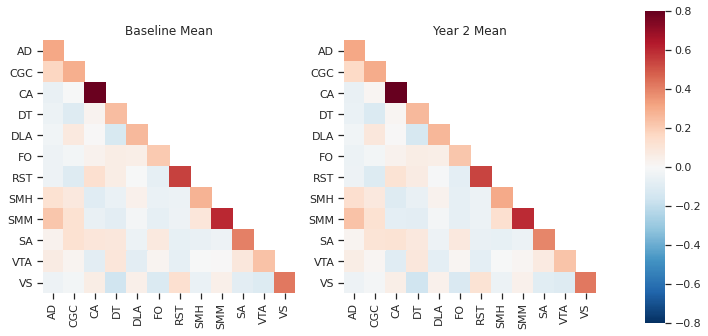

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(10,5),
                        gridspec_kw={'width_ratios': [1, 1, 0.08]})

sns.heatmap(label_2d(mean_baseline, network_codes), ax=axs[0], square=True,
            cmap='RdBu_r', vmin=-0.8, vmax=0.8, cbar=False)
axs[0].set_title('Baseline Mean')

sns.heatmap(label_2d(mean_year2, network_codes), ax=axs[1], square=True,
            cmap='RdBu_r', vmin=-0.8, vmax=0.8, cbar_ax=axs[2])
axs[1].set_title('Year 2 Mean')

plt.tight_layout()
plt.show()

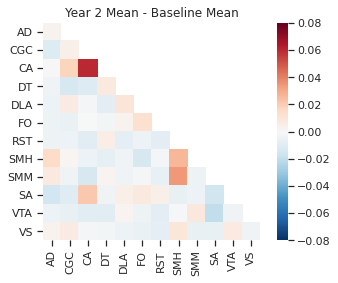

In [41]:
ax = sns.heatmap(label_2d(mean_year2 - mean_baseline, network_codes), square=True,
                 cmap='RdBu_r', vmin=-0.08, vmax=0.08)
ax.set_title('Year 2 Mean - Baseline Mean')

plt.show()

### Longitudinal Change

In [42]:
betnet_delta = (betnet_year2 - betnet_baseline).divide(age_month_diff / 12, axis=0)

In [43]:
mean_delta = columns_to_2d(betnet_delta.mean())

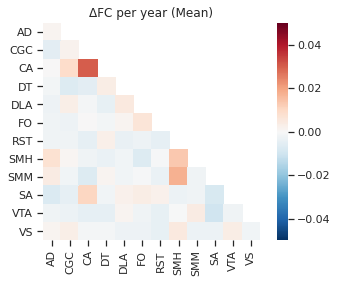

In [44]:
ax = sns.heatmap(label_2d(mean_delta, network_codes), square=True,
                 cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title('ΔFC per year (Mean)')

plt.show()

In [45]:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

tstats, pvals = ttest_1samp(betnet_delta, 0, nan_policy='omit')
betnet_delta_ttest_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

In [46]:
mean_delta_significant = columns_to_2d(betnet_delta.mean().mask(~betnet_delta_ttest_fdr[0], np.nan))

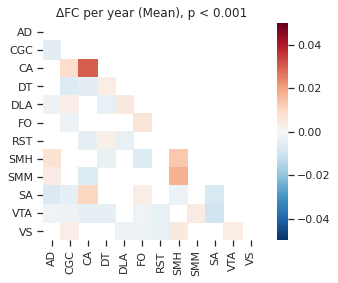

In [59]:
ax = sns.heatmap(label_2d(mean_delta_significant, network_codes), square=True,
                 cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title('ΔFC per year (Mean), p < 0.001')

plt.show()

#### Within, Between

In [60]:
def within_between(flat_tril):
    matrix = columns_to_2d(flat_tril)
    within = np.nanmean(matrix.diagonal())
    between = np.nanmean(matrix[np.tril_indices_from(matrix, k=-1)])
    return pd.Series([within, between], index=['within', 'between'])

betnet_baseline_within_between = betnet_baseline.apply(within_between, axis=1)
betnet_year2_within_between = betnet_year2.apply(within_between, axis=1)
betnet_delta_within_between = ((betnet_year2_within_between - betnet_baseline_within_between)
                               .divide(age_month_diff / 12, axis=0))

In [61]:
within_t_p = ttest_1samp(betnet_delta_within_between['within'], 0, alternative='greater')
between_t_p = ttest_1samp(betnet_delta_within_between['between'], 0, alternative='less')

In [62]:
print('mean within FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=betnet_delta_within_between['within'].mean(), p=within_t_p[1]))

mean within FC change = +0.0037, p = 2.2E-17


In [63]:
print('mean between FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=betnet_delta_within_between['between'].mean(), p=between_t_p[1]))

mean between FC change = -0.0009, p = 5.7E-12


Variables
* Target: Δ integration, Δ segregation
* Covariates: sex, baseline age, Δ age, race
    * mean FD?